# Classifying conditions: CorrectGo and NoGo

There are a number of steps to this. Hopefully we can recycle previous code and be up fairly quickly!

1. Load beta data. Ideally this process should include a cache into a pure python object so we don't have to reload it each time.
2. Preprocess the data.
3. Do cross-validated training and testing. Ideally an inner loop to select best parameters, an outer loop to get cross-validated performance, and final training over all the data to get an image. The inner loop can be probably be handled within the package we use probably.

In [22]:
import socket
import yaml
hostname=socket.gethostname()
hostname='zzz'
with open('sst_config.yml', "r") as f:
    test_config= yaml.safe_load(f)#[hostname]

In [23]:
import sys
import os
import pandas as pd
import numpy as np



sys.path.append(os.path.abspath("../../ml/"))
from apply_loocv_and_save import load_and_preprocess, load_and_preprocess_Brain_Data
from dev_utils import read_yaml_for_host
from dev_utils import get_2DX_from_4DX
import warnings


config_data = read_yaml_for_host("sst_config.yml")



In [24]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn import decomposition
#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif


In [25]:
import multiprocessing
import math
import nibabel as nib
import nilearn as nl
from nilearn.decoding import DecoderRegressor,Decoder
from sklearn.model_selection import KFold,GroupKFold,LeaveOneOut
cpus_available = multiprocessing.cpu_count()

cpus_to_use = min(cpus_available-1,math.floor(0.9*cpus_available))
print(cpus_to_use)

9


In [26]:
from dev_wtp_io_utils import cv_train_test_sets, asizeof_fmt
from dev_utils import sklearn_nested_cross_validate
from nilearn.decoding import DecoderRegressor,Decoder

In [27]:
nonbids_data_path = config_data['nonbids_data_path']
ml_data_folderpath = nonbids_data_path + "fMRI/ml"


## Set up the paradigm

In [28]:

def condition_resp_trans_func(X):
    reg_match = "Sn\(1\) (.*)\*bf\(1\)"
    return(X.raw_beta_description.str.extract(reg_match, expand=False))


## Loading beta data

beta data is generally written in `load_multisubject_brain_data_sst_w1.ipynb`.

We just have to load it.

In [29]:
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_30subs_correct_cond_pfc.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_6subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_nos_6subs_correct_cond_pfc.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_nos_30subs_correct_cond_pfc.pkl'
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_nos_181subs_correct_cond_pfc.pkl'


warnings.warn("not sure if this file holds up--it was created in 2021; need to see if it's still valid")
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20230102T164214.csv"

/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34130/706202569.py:8: UserWarning: not sure if this file holds up--it was created in 2021; need to see if it's still valid
  warnings.warn("not sure if this file holds up--it was created in 2021; need to see if it's still valid")


In [30]:


all_subjects = load_and_preprocess_Brain_Data(
    brain_data_filepath,
    train_test_markers_filepath,
    #subjs_to_use = None,
    response_transform_func = condition_resp_trans_func
    #clean=None
    )

warnings.warn("the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.")


checked for intersection and no intersection between the brain data and the subjects was found.
there were 173 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 72407
brain_data_filepath: 178
pkl_file: 168
train_test_markers_filepath: 158
response_transform_func: 144
Brain_Data_allsubs: 48
346
346


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_34130/3413544225.py:9: UserWarning: the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.
  warnings.warn("the data hasn't been cleaned at any point. the fMRIPrep cleaning pipeline has been applied; nothing else has been.")


In [31]:
from sklearn.feature_selection import SelectPercentile,f_classif

#convert the y array to an integer array representing the string values of the y array
all_subjects_y_cat = all_subjects.Y.astype('category')
all_subjects_y_int=all_subjects_y_cat.cat.codes

In [32]:
mask_nifti = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')

In [33]:


num_subjs = len(all_subjects.X['subject'].unique())
if num_subjs < len(all_subjects.X['subject'].unique()):
    #select subjs
    subjs = all_subjects.X['subject'].unique()
    subjs.sort()
    selected_sub_ids=subjs[0:num_subjs]
    selected_rows = all_subjects.X['subject'].isin(selected_sub_ids)
    selected_subjs = all_subjects[selected_rows]
    selected_subjs_y_int = all_subjects_y_int[selected_rows]
else:
    selected_subjs = all_subjects
    selected_subjs_y_int = all_subjects_y_int

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


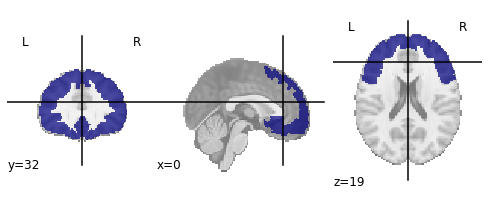

In [34]:
#visualize the mask that has alreayd been applied
nl.plotting.plot_roi(
selected_subjs.mask)

Looks good! I don't think we need to re-mask. But if we needed to, we could probably use apply_maks, right?

In [35]:
# # get the PFC mask
# mask_nifti = nib.load(ml_data_folderpath + '/prefrontal_cortex.nii.gz')
# selected_subjs_masked = selected_subjs.apply_mask(mask_nifti)
# nl.plotting.plot_roi(
#selected_subjs.mask)


The above code took 80 seconds just on a 6-subject dataset. And the mask that was printed looks identical to the previous one. And it seems to have somehow widened the field of view rather than narrowed it. So if we alredy have a pfc-masked dataset, we can skip this.

Transform our mask into the same space as the data


# Training

I'm going to start with `cv_train_test_sets` and see how that goes. It sems likely it'll have to be re-written somewhat, but it might be a good starting point.

I think I need to run this without all the extra scaffolding--just tresting the Decoder on the data until I get something sensible. At the very least we need to know the Decoder object is handling balanced classes correctly.

In [36]:
# use add PFC mask.ipynb to figure out how to get a PFC mask onto this data.

In [37]:
#import SVC
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SequentialFeatureSelector, SelectKBest


Here's a cross-validation function using sklearn. No feature selection yet, but I"ll build that in next.

In [38]:
not_na_cols=np.isnan(selected_subjs.data).all(axis=0)==False
cleaned_data=selected_subjs.data[:,not_na_cols]
#VarianceThreshold(threshold=0).fit(cleaned_data,selected_subjs_y_int)
selected_subjs.data=cleaned_data

In [39]:
#find out how many nan features there are in each sample
nan_features_per_sample = np.isnan(selected_subjs.data).sum(axis=1)
#find out which subject each of those samples are associated with
nan_features_per_sample_subjs = selected_subjs.X['subject'].iloc[nan_features_per_sample>0]
subjects_with_nan_features = nan_features_per_sample_subjs.unique()
print("there are " + str(len(subjects_with_nan_features)) + " subjects with nan features. all the subject data will be removed from the dataset")
#remove those subjects from the dataset
print(selected_subjs.X['subject'].nunique())
selected_subjs = selected_subjs[~selected_subjs.X['subject'].isin(subjects_with_nan_features)]
#okay, so it's just one subject. so we can remove them, and move on!
print(selected_subjs.X['subject'].nunique())

there are 0 subjects with nan features. all the subject data will be removed from the dataset
173
173


In [40]:
selected_subjs.X['subject'].iloc[nan_features_per_sample>0]

Series([], Name: subject, dtype: object)

In [41]:
pd.Series(nan_features_per_sample).value_counts()

0    346
dtype: int64

In [42]:
#try to get rid of this "values constant" warning by pre-removing constant features
from sklearn.feature_selection import VarianceThreshold
print(selected_subjs.data.shape)
X_data_thresholded = VarianceThreshold(threshold=0).fit_transform(selected_subjs.data,selected_subjs_y_int)
print(X_data_thresholded.shape)

(346, 40009)
(346, 39568)


In [43]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

estimators = [
    LinearSVC(penalty='l2',max_iter=1e6,class_weight='balanced'),
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced')

]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)

    
from dev_utils import sklearn_nested_cross_validate

cv_result = sklearn_nested_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs,
    groups=np.array(selected_subjs.X['subject']))
        
   

from sklearn.metrics import roc_auc_score


pd.Series(cv_result['y_predict_final']).value_counts()
roc_auc_score(selected_subjs_y_int,cv_result['y_predict_final'])

generalization test group 0
230
116
hyper-parameter search group 0;  est...est 0; ROC AUC: 0.5769230769230769; 
est...est 1; ROC AUC: 0.5897435897435898; 
hyper-parameter search group 1;  est...est 0; ROC AUC: 0.5789473684210525; 
est...est 1; ROC AUC: 0.5921052631578947; 
hyper-parameter search group 2;  est...est 0; ROC AUC: 0.5657894736842105; 
est...est 1; ROC AUC: 0.5921052631578947; 


generalization test group 1
230
116
hyper-parameter search group 0;  est...est 0; ROC AUC: 0.5897435897435898; 
est...est 1; ROC AUC: 0.5769230769230769; 
hyper-parameter search group 1;  est...est 0; ROC AUC: 0.5789473684210527; 
est...est 1; ROC AUC: 0.5789473684210527; 
hyper-parameter search group 2;  est...est 0; ROC AUC: 0.618421052631579; 
est...est 1; ROC AUC: 0.5921052631578947; 


generalization test group 2
232
114
hyper-parameter search group 0;  est...est 0; ROC AUC: 0.5128205128205128; 
est...est 1; ROC AUC: 0.5256410256410257; 
hyper-parameter search group 1;  est...est 0; ROC AUC: 0

0.5346820809248555

TO TRY NEXT: TRY CLASSIFYING WHOLE-BRAIN DATA, WITH PCA PRE-CLASSIFICATION IF NECESSARY.

This is getting quite frustrating--I've worked on this all sprint and I haven't been able to classify. It's possible that the information just doesn't exist in the data. Let's at least see whether we've done steps in this function alright.

What's the empirical distribution on classifying this number of samples and getting an AUC of 0.56?

In [71]:
#do a wilcox test (Mann-Whitney U test) to see if the difference in AUC significantly differs from 0.5
#include a confidence interval
from scipy.stats import wilcoxon
wilcoxon(cv_result['y_predict_final'],selected_subjs_y_int)

WilcoxonResult(statistic=6050.0, pvalue=2.693490359580543e-29)

Yes, seems to be! That's a good sign.

## create synthetic data

In [45]:
subjs_data_synth = selected_subjs.data.copy()
#now select some random features and augment them with some noisy outcome data
y_synth = selected_subjs_y_int

#let's do 50 features
n_features = 50
for i in range(n_features):
    #select a random feature to augment
    feature_to_augment = np.random.randint(0,subjs_data_synth.shape[1])
    #mix y_synth with some random data
    y_synth_noisy = y_synth + np.random.normal(0,0.1,y_synth.shape)
    #add the noisy data to the feature
    subjs_data_synth[:,feature_to_augment] = subjs_data_synth[:,feature_to_augment] + y_synth_noisy

print(subjs_data_synth.shape)

(3214, 40009)


In [46]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

estimators = [
    LinearSVC(penalty='l2',max_iter=1e6,class_weight='balanced'),
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced')

]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)

    

cv_result = sklearn_nested_cross_validate(
    subjs_data_synth,
    np.array(selected_subjs_y_int),
    estimators_with_fs,
    groups=np.array(selected_subjs.X['subject']))
        
   

from sklearn.metrics import roc_auc_score


pd.Series(cv_result['y_predict_final']).value_counts()
roc_auc_score(selected_subjs_y_int,cv_result['y_predict_final'])

generalization test group 0
2136
1078
hyper-parameter search group 0;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9841260906276386; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.9867154517309317; 
hyper-parameter search group 1;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9961890243902439; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.993140243902439; 
hyper-parameter search group 2;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9797250409165303; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.986088379705401; 


generalization test group 1
2142
1072
hyper-parameter search group 0;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9906008950126597; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.9952305246422893; 
hyper-parameter search group 1;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9727109006319933; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.9831246143840986; 
hyper-parameter search group 2;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9911504424778761; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.979646017699115; 


generalization test group 2
2150
1064
hyper-parameter search group 0;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9669380747590474; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.9657481854187562; 
hyper-parameter search group 1;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9991007194244604; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.9964028776978417; 
hyper-parameter search group 2;  est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 0; ROC AUC: 0.9923076923076923; 
est...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


est 1; ROC AUC: 0.9923076923076923; 


estimator_i
1    0.986489
0    0.985872
Name: score, dtype: Float64
chose estimator 1
generalization test group 0


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


generalization test group 1


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


generalization test group 2


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


cross-validated score is: 0.9826571409844662
precision, recall, fscore, support:
(array([0.99852235, 0.85996055]), array([0.97440519, 0.99090909]), array([0.98631637, 0.92080253]), array([2774,  440]))


/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


raw (overfit) score is: 1.0


0.9826571409844662

### with the simple classifier

That's odd. If we mix y data in with the X then, when we predict, the predictor should be able to pick up on those features and predict. something isn't right. Maybe we need to take out the nested CV and try it without that.

In [86]:
from dev_utils import sklearn_simple_cross_validate
print(subjs_data_synth.shape)
subjs_data_synth_cleaned = VarianceThreshold(threshold=0).fit_transform(subjs_data_synth)
subjs_data_synth_fs = SelectKBest(f_classif, k=200).fit_transform(subjs_data_synth_cleaned,selected_subjs_y_int)

print(subjs_data_synth_fs.shape)
estimator = LinearSVC(penalty='l2',max_iter=1e6,class_weight='balanced')

cv_result = sklearn_simple_cross_validate(
    subjs_data_synth_fs,
    np.array(selected_subjs_y_int),
    estimator,
    groups=np.array(selected_subjs.X['subject']))


(634, 40009)
(634, 200)
generalization test group 0, estimating... 

KeyboardInterrupt: 

In [81]:
#get a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(selected_subjs_y_int,cv_result['y_predict_final'])

array([[282, 254],
       [ 40,  58]])

Seems like it is working--but not very well. That's interesting because we have it pretty easy data to interpret!

Suggests maybe we haven't got the best algorithm? What if we tried ridge regression?

#### Add Ridge Regression

In [87]:
from sklearn.linear_model import RidgeClassifierCV


estimators = [
    LinearSVC(penalty='l2',max_iter=1e6,class_weight='balanced'),
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced'),
    RidgeClassifierCV(class_weight='balanced')

]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)


# cv_result_0 = sklearn_simple_cross_validate(
#     X_2d_masked_synth,
#     np.array(selected_subjs_y_int),
#     estimators_with_fs[0],
#     groups=np.array(selected_subjs.X['subject']))

cv_result_1 = sklearn_simple_cross_validate(
    subjs_data_synth_fs,
    np.array(selected_subjs_y_int),
    estimators_with_fs[1],
    groups=np.array(selected_subjs.X['subject']))

cv_result_2 = sklearn_simple_cross_validate(
    subjs_data_synth_fs,
    np.array(selected_subjs_y_int),
    estimators_with_fs[2],
    groups=np.array(selected_subjs.X['subject']))

generalization test group 0, estimating... estimated; predicting... 
generalization test group 1, estimating... estimated; predicting... 
generalization test group 2, estimating... estimated; predicting... 
cross-validated score is: 0.5622144380140115
precision, recall, fscore, support:
(array([0.87774295, 0.18730159]), array([0.52238806, 0.60204082]), array([0.65497076, 0.28571429]), array([536,  98]))
raw (overfit) score is: 1.0
generalization test group 0, estimating... estimated; predicting... 
generalization test group 1, estimating... estimated; predicting... 
generalization test group 2, estimating... estimated; predicting... 
cross-validated score is: 0.9400890953396284
precision, recall, fscore, support:
(array([0.98301887, 0.85576923]), array([0.97201493, 0.90816327]), array([0.97748593, 0.88118812]), array([536,  98]))
raw (overfit) score is: 1.0


In [88]:
confusion_matrix(cv_result_2['y_predict_final'],selected_subjs_y_int)

array([[521,   9],
       [ 15,  89]])

In [89]:
from sklearn.linear_model import RidgeClassifierCV


estimators = [
    LinearSVC(penalty='l2',max_iter=1e6,class_weight='balanced'),
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced'),
    RidgeClassifierCV(class_weight='balanced')

]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)


cv_result_1 = sklearn_simple_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs[1],
    groups=np.array(selected_subjs.X['subject']))

cv_result_2 = sklearn_simple_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs[2],
    groups=np.array(selected_subjs.X['subject']))

generalization test group 0, estimating... estimated; predicting... 
generalization test group 1, estimating... estimated; predicting... 
generalization test group 2, estimating... estimated; predicting... 
cross-validated score is: 0.5432911970758453
precision, recall, fscore, support:
(array([0.86627907, 0.17931034]), array([0.55597015, 0.53061224]), array([0.67727273, 0.26804124]), array([536,  98]))
raw (overfit) score is: 0.9152832774901006
generalization test group 0, estimating... estimated; predicting... 
generalization test group 1, estimating... estimated; predicting... 
generalization test group 2, estimating... estimated; predicting... 
cross-validated score is: 0.500780536095035
precision, recall, fscore, support:
(array([0.84575835, 0.15510204]), array([0.61380597, 0.3877551 ]), array([0.71135135, 0.22157434]), array([536,  98]))
raw (overfit) score is: 0.8492803837953092


In [90]:
confusion_matrix(cv_result_2['y_predict_final'],np.array(selected_subjs_y_int))

array([[329,  60],
       [207,  38]])

Okay. Another way to get a feel for how good this is is to change the grouping indicator, to, say, perhaps just a shuffled subject group. 
That is 'cheating' in a way because we're learning within-subject, to a degree, but this might be useful for understanding the behavior of the algorithms I'm testing out.

In [91]:
import time


timestamp=int(time.time())


In [94]:
from sklearn.linear_model import RidgeClassifierCV

#create a random seed based on the current timestamp

#timestamp=int(time.time())
np.random.seed(1672890861)
#shuffle the groups randomly
groups_shuffled = selected_subjs.X['subject'].sample(frac=1).values

estimators = [
    #LinearSVC(penalty='l2',max_iter=1e6,class_weight='balanced'),
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced'),
    RidgeClassifierCV(class_weight='balanced')

]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)

# cv_result_0 = sklearn_simple_cross_validate(
#     selected_subjs.data,
#     np.array(selected_subjs_y_int),
#     estimators_with_fs[1],
#     groups=np.array(groups_shuffled))

cv_result_1 = sklearn_simple_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs[0],
    groups=np.array(groups_shuffled))

cv_result_2 = sklearn_simple_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs[1],
    groups=np.array(groups_shuffled))

generalization test group 0, estimating... estimated; predicting... 
generalization test group 1, estimating... estimated; predicting... 
generalization test group 2, estimating... estimated; predicting... 
cross-validated score is: 0.5025319829424307
precision, recall, fscore, support:
(array([0.84657534, 0.15613383]), array([0.57649254, 0.42857143]), array([0.68590455, 0.22888283]), array([536,  98]))
raw (overfit) score is: 0.9152832774901006
generalization test group 0, estimating... estimated; predicting... 
generalization test group 1, estimating... estimated; predicting... 
generalization test group 2, estimating... estimated; predicting... 
cross-validated score is: 0.5112701797136766
precision, recall, fscore, support:
(array([0.84955752, 0.16483516]), array([0.71641791, 0.30612245]), array([0.77732794, 0.21428571]), array([536,  98]))
raw (overfit) score is: 0.8492803837953092


Really odd, and kind of worrying, to see that we can't classify better than chance even when we shuffle the groups.

### Do cross-validation

That's kind of a bad sign? This suggests we can't even really learn within-subject. Whatever else, you'd think we could at least do that.

If we can't learn within-subject, then I am _very_ sceptical that just throwing more subjects at this will get us better results.

By the way, now that we've found a (practically perfect) classifier of the synthetic data, I do want to run it through the nested cross-validator to ensure that the nested cross-validator works.

In [95]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#I'll add the feature selection step for the estimators here for now,
#but to save time we could add separate functions for preprocessing
#advantage of doing it independently from estimators would be to avoid running feature selection twice.
#disadvantage would be that we'd have to pass the feature

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

estimators = [
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced'),
    RidgeClassifierCV(class_weight='balanced')
]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)

    
#from dev_utils import sklearn_nested_cross_validate

cv_result = sklearn_nested_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs,
    groups=np.array(selected_subjs.X['subject']))
        
   

from sklearn.metrics import roc_auc_score


pd.Series(cv_result['y_predict_final']).value_counts()
roc_auc_score(selected_subjs_y_int,cv_result['y_predict_final'])

generalization test group 0
439
195
hyper-parameter search group 0
327
112
estimating...estimator 0; ROC AUC score: 0.6041666666666666
estimating...estimator 1; ROC AUC score: 0.46875
hyper-parameter search group 1
327
112
estimating...estimator 0; ROC AUC score: 0.6458333333333334
estimating...estimator 1; ROC AUC score: 0.5364583333333334
hyper-parameter search group 2
224
215
estimating...estimator 0; ROC AUC score: 0.5356579984239558
estimating...estimator 1; ROC AUC score: 0.48532308904649335
generalization test group 1
414
220
hyper-parameter search group 0
301
113
estimating...estimator 0; ROC AUC score: 0.4439338235294118
estimating...estimator 1; ROC AUC score: 0.43566176470588236
hyper-parameter search group 1
302
112
estimating...estimator 0; ROC AUC score: 0.578125
estimating...estimator 1; ROC AUC score: 0.5885416666666666
hyper-parameter search group 2
225
189
estimating...estimator 0; ROC AUC score: 0.4026565464895635
estimating...estimator 1; ROC AUC score: 0.5453510436

0.5432911970758453

## Classifying _within_ subject

Can we at least do a classification _within_ subject? If we can't do _that_, we're in trouble, maybe.

In [128]:


estimators = [
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced'),
    RidgeClassifierCV(class_weight='balanced')
]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for estimator in estimators:
    estimator_with_fs = Pipeline([
        ('clean',VarianceThreshold(threshold=0)),
        ('select', SelectKBest(f_classif, k=200)),
        ('estimator', estimator)])
    estimators_with_fs.append(estimator_with_fs)

    
#from dev_utils import sklearn_nested_cross_validate

for subj in np.unique(selected_subjs.X['subject']):
    #do classification one subject at a time.
    this_subj_samples = selected_subjs.X['subject']==subj
    print(subj)

    #create some pseudogroups, ensuring that each group has some of each outcome type
    this_subj_y = selected_subjs_y_int[this_subj_samples]
    group_size = this_subj_y.value_counts().min()
    #now assign every item in each sample to a number between 1 and group_size
    #cumulatively number each item type in the sample
    pseudo_groups = this_subj_y.groupby(this_subj_y).cumcount() % group_size + 1
    

    cv_result = sklearn_nested_cross_validate(
        selected_subjs[this_subj_samples].data,
        np.array(this_subj_y),
        estimators_with_fs,
        groups=np.array(pseudo_groups))

    print(pd.Series(cv_result['y_predict_final']).value_counts())
    print(roc_auc_score(this_subj_y,cv_result['y_predict_final']))

DEV011
generalization test group 0
72
36
hyper-parameter search group 0
50
22
estimating...estimator 0; ROC AUC score: 0.39473684210526316
estimating...estimator 1; ROC AUC score: 0.5
hyper-parameter search group 1
50
22
estimating...estimator 0; ROC AUC score: 0.587719298245614
estimating...estimator 1; ROC AUC score: 0.4473684210526316
hyper-parameter search group 2
44
28
estimating...estimator 0; ROC AUC score: 0.5833333333333334
estimating...estimator 1; ROC AUC score: 0.375
generalization test group 1
72
36
hyper-parameter search group 0
50
22
estimating...estimator 0; ROC AUC score: 0.7017543859649122
estimating...estimator 1; ROC AUC score: 0.4736842105263158
hyper-parameter search group 1
50
22
estimating...estimator 0; ROC AUC score: 0.42105263157894735
estimating...estimator 1; ROC AUC score: 0.6140350877192982
hyper-parameter search group 2
44
28
estimating...estimator 0; ROC AUC score: 0.5833333333333334
estimating...estimator 1; ROC AUC score: 0.5833333333333333
generaliza

## Other attempts at feature selection

OK, this should make us really sceptical there is good data here. The fact that the overfit score is high shows that on some shallow level, the classification is working--it just isn't picking up signal. It might be worth adding a PCA I suppose.

In [16]:
40000/256

156.25

In [17]:


estimators = [
    LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced'),
    LogisticRegression(penalty='l2',solver='liblinear',class_weight='balanced'),
    RidgeClassifierCV(class_weight='balanced')
]
estimators_with_fs = []
#now wrap the estimators in a pipeline that does feature selection
for decomp_prop in [2,4,8,16,32]:#[4,16,64,256]:
    #decomp_components = (int)(selected_subjs.data.shape[1]/decomp_prop)
    decomp_components = (int)(min(selected_subjs.data.shape)/decomp_prop)
    print(str(decomp_components) + ' components')
    for estimator in estimators:
        estimator_with_fs = Pipeline([
            ('clean',VarianceThreshold(threshold=0)),
            ('decompose', decomposition.PCA(n_components=decomp_components)),
            #('select', SelectKBest(f_classif, k=150)),
            ('estimator', estimator)])
        estimators_with_fs.append(estimator_with_fs)

    
#from dev_utils import sklearn_nested_cross_validate

cv_result = sklearn_nested_cross_validate(
    selected_subjs.data,
    np.array(selected_subjs_y_int),
    estimators_with_fs,
    groups=np.array(selected_subjs.X['subject']))
        
   

from sklearn.metrics import roc_auc_score


pd.Series(cv_result['y_predict_final']).value_counts()
roc_auc_score(selected_subjs_y_int,cv_result['y_predict_final'])

317
158
79
39
19
generalization test group 0
439
195
hyper-parameter search group 0
327
112
estimating...estimator 0; ROC AUC score: 0.4791666666666666
estimating...estimator 1; ROC AUC score: 0.4322916666666667
estimating...estimator 2; ROC AUC score: 0.4479166666666667
estimating...estimator 3; ROC AUC score: 0.5104166666666666
estimating...

/Users/benjaminsmith/opt/anaconda3/envs/neuralsignature/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


estimator 4; ROC AUC score: 0.5364583333333333
estimating...estimator 5; ROC AUC score: 0.5
estimating...estimator 6; ROC AUC score: 0.4947916666666667
estimating...estimator 7; ROC AUC score: 0.4895833333333333
estimating...estimator 8; ROC AUC score: 0.5
estimating...estimator 9; ROC AUC score: 0.4947916666666667
estimating...estimator 10; ROC AUC score: 0.4947916666666667
estimating...estimator 11; ROC AUC score: 0.5
estimating...estimator 12; ROC AUC score: 0.546875
estimating...estimator 13; ROC AUC score: 0.5364583333333334
estimating...estimator 14; ROC AUC score: 0.4947916666666667
hyper-parameter search group 1
327
112
estimating...estimator 0; ROC AUC score: 0.515625
estimating...estimator 1; ROC AUC score: 0.53125
estimating...estimator 2; ROC AUC score: 0.53125
estimating...